# クラス分類学習モデルの作成、予測の実行

In [1]:
import os
import random

# basic DS libraries
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# plot libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

# from sklearn.decomposition import PCA  # 主成分分析

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# データセット分割・評価検証
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# config python file
import config

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

# ファイル保存関数（dirがなければ生成する）
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# seedの固定
def fix_seed(seed: int):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)


# 再現性をもたせるためのseed固定
SEED = config.SEED
fix_seed(SEED)

# 決定木クラス分類モデルの作成・実行

決定木クラス分類モデルを作成、実行し、クラス分類に有用な特徴量を見つける  
精度は重視しない

In [2]:
df_MB_OS_status_in_5years_dropped = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_DIR
    + "/3.4-df_MB_OS_status_in_5years_dropped.pkl"
)
df_MB_OS_status_in_5years_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042 entries, 0 to 1123
Data columns (total 56 columns):
 #   Column                                                          Non-Null Count  Dtype
---  ------                                                          --------------  -----
 0   LYMPH_NODES_EXAMINED_POSITIVE                                   1042 non-null   bool 
 1   NPI                                                             1042 non-null   bool 
 2   CELLULARITY                                                     1042 non-null   bool 
 3   CHEMOTHERAPY                                                    1042 non-null   bool 
 4   ER_IHC                                                          1042 non-null   bool 
 5   HER2_SNP6                                                       1042 non-null   bool 
 6   HORMONE_THERAPY                                                 1042 non-null   bool 
 7   INFERRED_MENOPAUSAL_STATE                                       1042 

# 学習データ分割

1. X（説明変数）とy（目的変数）に分割(y=df['target'])
2. train_test_splitによる基本的なデータ分割（train:test=75%:25%）※層化検証など他の分割手法は後で実施  

In [3]:
# Xとyに分割
X = df_MB_OS_status_in_5years_dropped.drop("target", axis=1)
y = df_MB_OS_status_in_5years_dropped["target"]
display(X.tail(), y.tail(), y.value_counts())

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,AGE_AT_DIAGNOSIS,RADIO_THERAPY,ER_STATUS,HER2_STATUS,GRADE,PR_STATUS,TUMOR_SIZE,TUMOR_STAGE,TMB_NONSYNONYMOUS,COHORT_2.0,COHORT_3.0,COHORT_5.0,INTCLUST_10,INTCLUST_2,INTCLUST_3,INTCLUST_4ER+,INTCLUST_4ER-,...,CLAUDIN_SUBTYPE_Her2,CLAUDIN_SUBTYPE_LumA,CLAUDIN_SUBTYPE_LumB,CLAUDIN_SUBTYPE_NC,CLAUDIN_SUBTYPE_Normal,CLAUDIN_SUBTYPE_claudin-low,THREEGENE_ER+/HER2- Low Prolif,THREEGENE_ER-/HER2-,THREEGENE_HER2+,HISTOLOGICAL_SUBTYPE_Lobular,HISTOLOGICAL_SUBTYPE_Medullary,HISTOLOGICAL_SUBTYPE_Mixed,HISTOLOGICAL_SUBTYPE_Mucinous,HISTOLOGICAL_SUBTYPE_Other,HISTOLOGICAL_SUBTYPE_Tubular/ cribriform,BREAST_SURGERY_MASTECTOMY,LATERALITY_Right,CANCER_TYPE_DETAILED_Breast Invasive Ductal Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Lobular Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Mixed Mucinous Carcinoma,CANCER_TYPE_DETAILED_Breast Mixed Ductal and Lobular Carcinoma,ONCOTREE_CODE_IDC,ONCOTREE_CODE_ILC,ONCOTREE_CODE_IMMC,ONCOTREE_CODE_MDLC
1119,True,True,True,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True
1120,False,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True
1121,False,True,True,False,True,True,False,True,True,False,True,True,True,True,True,True,True,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,True,False,False,False,True,False,False,False
1122,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True
1123,False,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False


1119    False
1120    False
1121    False
1122    False
1123    False
Name: target, dtype: bool

False    844
True     198
Name: target, dtype: int64

In [4]:
# trainとtestに分割

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.SEED)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
display(y_train.value_counts(), y_test.value_counts())

(781, 55)

(261, 55)

(781,)

(261,)

False    638
True     143
Name: target, dtype: int64

False    206
True      55
Name: target, dtype: int64

# 2値分類モデル

In [5]:
def show_scores(y_test: pd.Series, y_pred_tree: pd.Series):
    print("accuracy: ", accuracy_score(y_test, y_pred_tree))
    print("precision: ", precision_score(y_test, y_pred_tree))
    print("recall: ", recall_score(y_test, y_pred_tree))
    print("f1 score: ", f1_score(y_test, y_pred_tree))

In [6]:
def show_confusion_matrix(
    y_test: pd.Series,
    y_pred: pd.Series,
    model_name: str = "confusion matrix",
    display_details: bool = False,
):
    cm = confusion_matrix(y_test, y_pred, normalize="all", labels=[True, False])
    df_cm = pd.DataFrame(data=cm, index=[True, False], columns=[True, False])

    fig = plt.figure()
    sns.heatmap(df_cm, square=True, cbar=True, annot=True, cmap="Blues")
    plt.title(model_name)
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.plot()

    if display_details:
        tn, fp, fn, tp = cm.ravel()
        print("tn: ", tn, "\nfp: ", fp, "\nfn:", fn, "\ntp:", tp)
        show_scores(y_test, y_pred)

## ベースラインの精度

全てFalseと予測（学習データはFalseが多いため）した場合のスコア

False    206
True      55
Name: target, dtype: int64

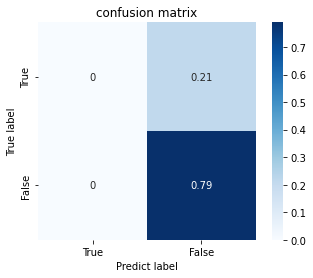

In [7]:
y_base = pd.Series([False for i in range(y_test.shape[0])], index=y_test.index)
display(y_test.value_counts())
show_confusion_matrix(y_test, y_base)

# 様々な機械学習手法の比較

様々な機械学習手法を用いて2値分類を行う。  
簡単に精度を見るため、再現性は担保されていない（引数にrandom_stateを要求しないclfもあるため）ので、必要に応じて再度モデルを構築すること。  
また、パラメータはデフォルト値を使用している。  
そのためパラメータ次第では結果が向上、下降しうる（決定木のf1など）。  

In [8]:
names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "Polynomial SVM",
    "RBF SVM",
    "Sigmoid SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    # "Linear Discriminant Analysis", # predictメソッドに対応していない
    "Quadratic Discriminant Analysis",
]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    # LDA(),
    QDA(),
]

/home/mono-clone/anaconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mono-clone/anaconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,train,test,f1
Naive Bayes,0.216389,0.226054,0.348387
Quadratic Discriminant Analysis,0.216389,0.229885,0.345277
Decision Tree,0.965429,0.758621,0.336842
Random Forest,0.965429,0.773946,0.305882
Nearest Neighbors,0.854033,0.781609,0.240000
Logistic Regression,0.830986,0.796935,0.208955
AdaBoost,0.819462,0.793103,0.205882
Polynomial SVM,0.845070,0.804598,0.190476
Linear SVM,0.816901,0.789272,0.000000
RBF SVM,0.816901,0.789272,0.000000


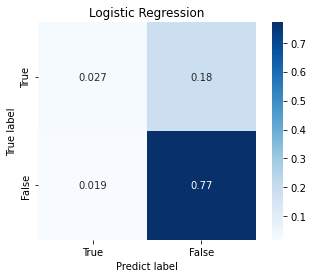

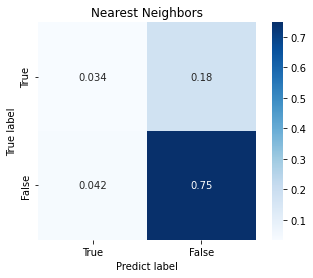

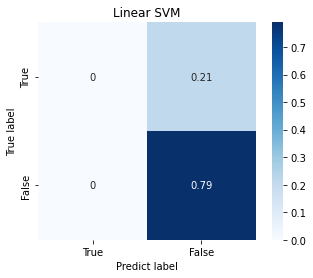

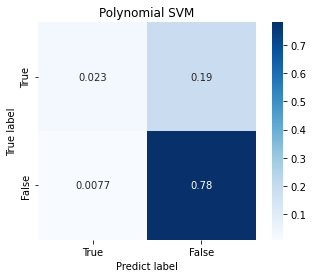

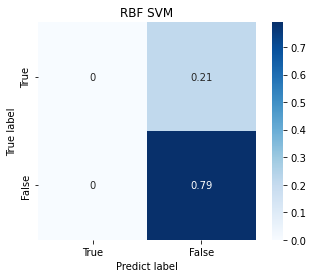

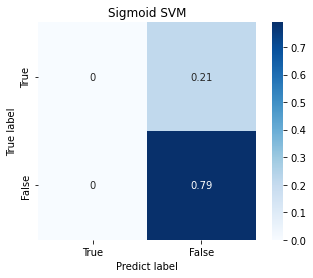

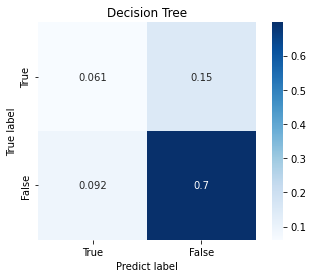

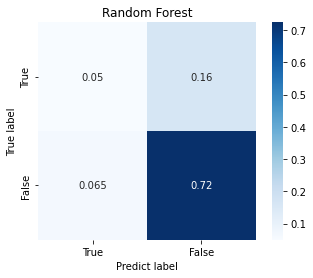

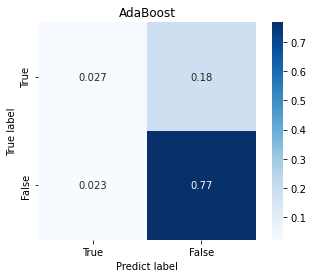

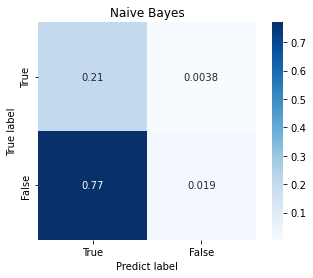

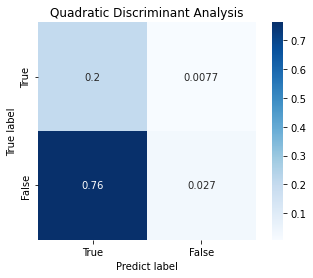

In [9]:
result = []
for name, clf in zip(names, classifiers):  # 指定した複数の分類機を順番に呼び出す
    # display(name)
    clf.fit(X_train, y_train)  # 学習
    score_train = clf.score(X_train, y_train)  # 正解率（train）の算出
    score_test = clf.score(X_test, y_test)  # 正解率（test）の算出
    y_pred = clf.predict(X_test)
    score_f1 = f1_score(y_test, y_pred)
    show_confusion_matrix(y_test, y_pred, model_name=name)
    result.append([score_train, score_test, score_f1])  # 結果の格納
    # display("-----" * 10)

df_result = pd.DataFrame(
    result, columns=["train", "test", "f1"], index=names
).sort_values("f1", ascending=False)

display(df_result)

In [10]:
import warnings

warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示

result = []
for trial in range(20):  # 20 回繰り返し、指標の平均を見る
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4
    )  # 訓練データ・テストデータの生成
    for name, clf in zip(names, classifiers):  # 指定した複数の分類機を順番に呼び出す
        clf.fit(X_train, y_train)  # 学習
        score_train = clf.score(X_train, y_train)  # 正解率（train）の算出
        score_test = clf.score(X_test, y_test)  # 正解率（test）の算出
        y_pred = clf.predict(X_test)
        score_f1 = f1_score(y_test, y_pred)
        result.append([name, score_train, score_test, score_f1])  # 結果の格納

df_result = pd.DataFrame(
    result, columns=["classifier", "train", "test", "f1"]
)  # 今回はまだ並べ替えはしない
df_result_mean = (
    df_result.groupby("classifier").mean().sort_values("f1", ascending=False)
)
display(df_result_mean)

warnings.filterwarnings("always")

,train,test,f1
classifier,,,
Quadratic Discriminant Analysis,0.29216,0.284173,0.334316
Naive Bayes,0.23720,0.234652,0.330972
Decision Tree,0.97296,0.732254,0.300546
Random Forest,0.97296,0.784173,0.273642
Logistic Regression,0.83072,0.800839,0.263263
AdaBoost,0.82512,0.793645,0.259773
Nearest Neighbors,0.85136,0.790048,0.256796
Polynomial SVM,0.85008,0.811151,0.234746
Linear SVM,0.81952,0.801799,0.058283


In [11]:
df_result_max = df_result.groupby("classifier").max().sort_values("f1", ascending=False)
display(df_result_max)

,train,test,f1
classifier,,,
Random Forest,0.9808,0.812950,0.390625
Decision Tree,0.9808,0.769784,0.376623
Quadratic Discriminant Analysis,0.3936,0.407674,0.352941
Naive Bayes,0.3504,0.304556,0.351240
Polynomial SVM,0.8768,0.841727,0.316667
AdaBoost,0.8448,0.824940,0.306452
Nearest Neighbors,0.8736,0.812950,0.303571
Logistic Regression,0.8496,0.836930,0.303030
Linear SVM,0.8464,0.822542,0.267857


デフォルト値のままではf1スコアが出ない  
→全て負事例（0: 5年後も生存）で予測しているケースが多い（多少は正事例（1: 5年以内に死亡）としているケースもあるが）

# ロジスティック回帰モデル

発生確率を予測する手法  
予測結果が0~1の間を取る  

In [12]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
# 訓練データでの正答率
clf_lr.score(X_train, y_train)

0.8064

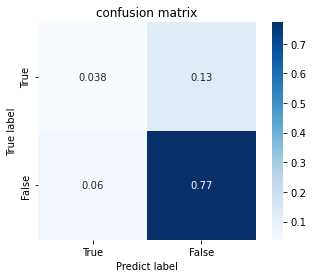

In [13]:
y_pred_lr = clf_lr.predict(X_test)
show_confusion_matrix(y_test, y_pred_lr)

# 決定木モデル
 
sklearnの決定木モデルを作成する。  
精度の高いモデルを選びたいので、葉の数を2~50まで変動させ、accuracyを見る

## 決定木モデルの構築・検証

決定木モデルを構築し、検証していく。  
パラメータを操作するため、forループで回し、最もスコアの高いものを見ていく。

In [14]:
import warnings

warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示

accuracies_tree = {}
precisions_tree = {}
recalls_tree = {}
f1_scores_tree = {}

for nodes_num in range(2, 50):
    clf_tree = DecisionTreeClassifier(
        max_leaf_nodes=nodes_num, random_state=config.SEED
    )
    clf_tree = clf_tree.fit(X_train, y_train)

    y_pred_tree = clf_tree.predict(X_test)

    accuracies_tree[nodes_num] = accuracy_score(y_test, y_pred_tree)
    precisions_tree[nodes_num] = precision_score(y_test, y_pred_tree)
    recalls_tree[nodes_num] = recall_score(y_test, y_pred_tree)
    f1_scores_tree[nodes_num] = f1_score(y_test, y_pred_tree)

    print("nodes_num: ", nodes_num)
    show_scores(y_test, y_pred_tree)
    print("----------" * 10)

warnings.filterwarnings("always")

nodes_num:  2
accuracy:  0.8321342925659473
precision:  0.0
recall:  0.0
f1 score:  0.0
----------------------------------------------------------------------------------------------------
nodes_num:  3
accuracy:  0.8321342925659473
precision:  0.0
recall:  0.0
f1 score:  0.0
----------------------------------------------------------------------------------------------------
nodes_num:  4
accuracy:  0.8321342925659473
precision:  0.0
recall:  0.0
f1 score:  0.0
----------------------------------------------------------------------------------------------------
nodes_num:  5
accuracy:  0.8321342925659473
precision:  0.0
recall:  0.0
f1 score:  0.0
----------------------------------------------------------------------------------------------------
nodes_num:  6
accuracy:  0.8321342925659473
precision:  0.0
recall:  0.0
f1 score:  0.0
----------------------------------------------------------------------------------------------------
nodes_num:  7
accuracy:  0.8321342925659473
precision: 

'max nodes_num'

2

22

35

22

accuracy:  0.7649880095923262
precision:  0.32926829268292684
recall:  0.38571428571428573
f1_score:  0.35526315789473684


Text(0, 0.5, 'score')

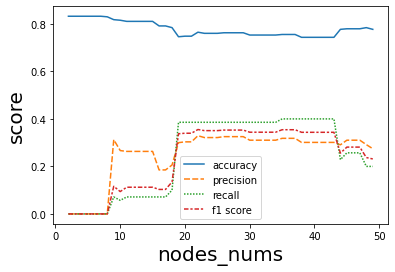

In [15]:
# 各スコアのプロット
display(
    "max nodes_num",
    max(accuracies_tree, key=accuracies_tree.get),
    max(precisions_tree, key=precisions_tree.get),
    max(recalls_tree, key=recalls_tree.get),
    max(f1_scores_tree, key=f1_scores_tree.get),
)

# f1_scoreが最も高いモデルのスコア
print(
    "accuracy: ",
    accuracies_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "precision: ",
    precisions_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "recall: ",
    recalls_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "f1_score: ",
    f1_scores_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)

df_score_tree = pd.DataFrame(
    [accuracies_tree, precisions_tree, recalls_tree, f1_scores_tree],
    index=["accuracy", "precision", "recall", "f1 score"],
    columns=accuracies_tree.keys(),
).T
p = sns.lineplot(data=df_score_tree)
p.set_xlabel("nodes_nums", fontsize=20)
p.set_ylabel("score", fontsize=20)

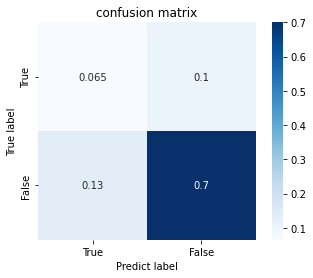

In [16]:
clf_tree = DecisionTreeClassifier(
    max_leaf_nodes=max(f1_scores_tree, key=f1_scores_tree.get),
    random_state=config.SEED,
)
clf_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
show_confusion_matrix(y_test, y_pred_tree)